In [221]:
import numpy as np
import sys
#!{sys.executable} -m pip install do_mpc
import do_mpc
# !{sys.executable} -mpip install slycot  
# !{sys.executable} -mpip install control
import control
# import slycot
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from math import inf, pi, sin, cos
# !{sys.executable} -m pip install --upgrade scipy
from scipy.integrate import odeint
import matplotlib.animation as animation

# Semestralni prace

## Parametry systemu (inverse pendulum)

In [222]:
M = .5
m = 0.2
b = 0.1
I = 0.006
g = 9.8
l = 0.3

### State space Vector:

\begin{bmatrix}
       x \\
       \dot{x} \\
       \theta \\
       \dot{\theta}
 \end{bmatrix}

In [223]:
p = I*(M+m)+M*m*l**2

In [224]:
A = [[0,      1,              0,           0],
     [0, -(I+m*l**2)*b/p,  (m**2*g*l**2)/p,   0],
     [0,      0,              0,           1],
     [0, -(m*l*b)/p,       m*g*l*(M+m)/p,  0]]

B = [[     0],
     [(I+m*l**2)/p],
     [     0],
     [   m*l/p]]

C = [[1, 0, 0, 0],
     [0, 0, 1, 0]]

D = [[0],
     [0]]


print(A)
print(B)
print(C)
print(D)

[[0, 1, 0, 0], [0, -0.18181818181818182, 2.6727272727272737, 0], [0, 0, 0, 1], [0, -0.45454545454545453, 31.181818181818183, 0]]
[[0], [1.8181818181818181], [0], [4.545454545454545]]
[[1, 0, 0, 0], [0, 0, 1, 0]]
[[0], [0]]


In [225]:
sys = control.StateSpace(A, B, C, D)

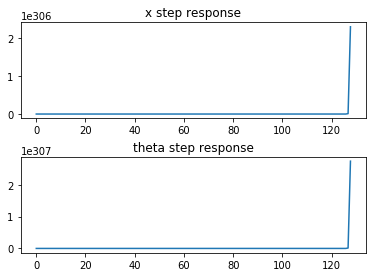

In [226]:
response = control.step_response(sys)

fig, axs = plt.subplots(2)
axs[0].plot(response.time, response.outputs[0][0])
axs[0].set_title('x step response')
axs[1].plot(response.time, response.outputs[1][0])
axs[1].set_title('theta step response')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)


In [227]:
w, v = np.linalg.eig(A)

In [228]:
print(w) # eigenvalues (vlastni cisla), jedno je kladne -> system je nestabilni

[ 0.         -0.14283164 -5.60409413  5.56510758]


## Controllability and observability

In [229]:
# Making controllability gram matrix:

R = control.ctrb(A, B) # [B, A*B, A^2*B, A^3*B]
print(R)
print(np.linalg.matrix_rank(R))

[[  0.           1.81818182  -0.33057851  12.20886551]
 [  1.81818182  -0.33057851  12.20886551  -4.42865924]
 [  0.           4.54545455  -0.82644628 141.88580015]
 [  4.54545455  -0.82644628 141.88580015 -31.319582  ]]
4


## State feedback controller:

In [230]:
# Place new poles, so the system would be stable: 

des_eig = [-1.1, -1.2, -1.3, -1.4]
K = control.place(A, B, des_eig)

print(K)

[[-0.05393143 -0.27397959  8.93857257  1.16959184]]


In [231]:
# New eigenvalues of the close loop system with state controller, so the system is now stable:

w_n, v_n = np.linalg.eig(A-B*K)
print(w_n)

[-1.4 -1.3 -1.2 -1.1]


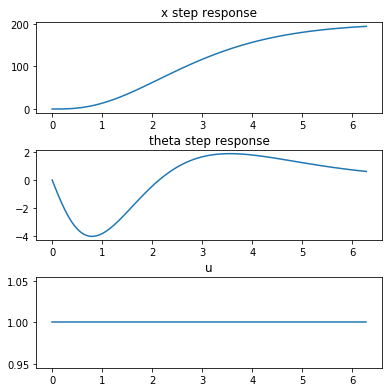

In [232]:
# trying out step on system with state controller: 

state_ctrl_fdbk_sys = control.StateSpace(A-B*K, -K.transpose(), C, D)

response_state_ctrl = control.step_response(state_ctrl_fdbk_sys)

fig, axs = plt.subplots(3)
axs[0].plot(response_state_ctrl.time, response_state_ctrl.outputs[0][0])
axs[0].set_title('x step response')
axs[1].plot(response_state_ctrl.time, response_state_ctrl.outputs[1][0])
axs[1].set_title('theta step response')
axs[2].plot(response_state_ctrl.time, response_state_ctrl.inputs[0][0])
axs[2].set_title('u')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.3, 
                    wspace=0.4, 
                    hspace=0.4)

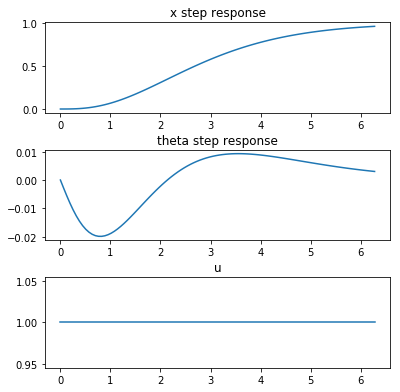

In [233]:
# rescaling:

k_ctrl_fdbk = control.dcgain(state_ctrl_fdbk_sys)
kr = [1/k_ctrl_fdbk[0][0], 1, 1/k_ctrl_fdbk[1][0], 1]

state_ctrl_fdbk_sys = control.StateSpace(A-B*K, -K.transpose(), C, D)

state_ctrl_fdbk_sys *= kr

response_state_ctrl = control.step_response(state_ctrl_fdbk_sys)

fig, axs = plt.subplots(3)
axs[0].plot(response_state_ctrl.time, response_state_ctrl.outputs[0][0])
axs[0].set_title('x step response')
axs[1].plot(response_state_ctrl.time, response_state_ctrl.outputs[1][0])
axs[1].set_title('theta step response')
axs[2].plot(response_state_ctrl.time, response_state_ctrl.inputs[0][0])
axs[2].set_title('u')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.3, 
                    wspace=0.4, 
                    hspace=0.4)

## LQR controller design with control lib. python:

In [234]:
Q = [[1, 0, 0, 0],[0, 0.1, 0, 0],[0, 0, 5, 0],[0, 0, 0, 0.1]]             # state cost matrix
R = [[0.05]]                                                              # input cost matrix

global K_lqr
K_lqr, S, E = control.lqr(sys, Q, R)

print(K_lqr)

[[-4.47213595 -5.06393848 31.65583773  5.91788676]]


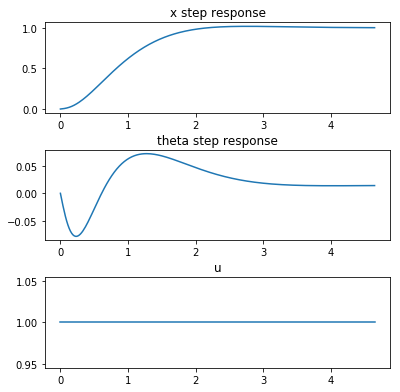

In [235]:
sys_lqr = control.StateSpace(A-B*K_lqr, -K_lqr.transpose(), C, D)

k_lqr = control.dcgain(sys_lqr)
kr = [1/k_lqr[0][0], 1, 1/k_lqr[1][0], 1]

sys_lqr *= kr                              # rescailing

response_lqr = control.step_response(sys_lqr)

fig, axs = plt.subplots(3)
axs[0].plot(response_lqr.time, response_lqr.outputs[0][0])
axs[0].set_title('x step response')
axs[1].plot(response_lqr.time, response_lqr.outputs[1][0])
axs[1].set_title('theta step response')
axs[2].plot(response_lqr.time, response_lqr.inputs[0][0])
axs[2].set_title('u')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.3, 
                    wspace=0.4, 
                    hspace=0.4)

## Simulating nonlinear model of inverted pendulum with inputs (scipy.integrate.odeint)

### Mathematical equations for inverted pendulum:



1) $(I + m.l^2) \cdot \ddot{\theta} - m.g.l.\theta = m.l.\ddot{x}$

2) $(M + m) \cdot \ddot{x} + b.\dot{x} - m.l.\ddot{\theta} = F$

          _|  |_
          \    /
           \  /
            \/
                    
1) $\ddot{\theta} = \frac{m.l}{(I+m.l^2)} \cdot \ddot{x} + \frac{m.g.l}{I+m.l^2} \cdot \dot{\theta}$

2) $ \ddot{x} = \frac{-b}{(M+m)} \cdot \dot{x} + \frac{m.l}{M+m} \cdot \ddot{\theta} + F$

          _|  |_
          \    /
           \  /
            \/
            
  $q = (I+m.l^2) \cdot (M+m) - (m.l)^2$
  
1) $ \ddot{x} = \frac{-b.(I+ml^2)}{q} \cdot \dot{x} + \frac{g.(ml)^2}{q} \cdot \dot{\theta} + \frac{(M+m)(I+ml^2)}{q} \cdot F$ 



2) $\ddot{\theta} = \frac{-b.m.l}{q} \cdot \dot{x} + \frac{m.l.(M+m)}{q} \cdot F + \frac{m.g.l.(I+m.l^2)}{q} \cdot \dot{\theta}$


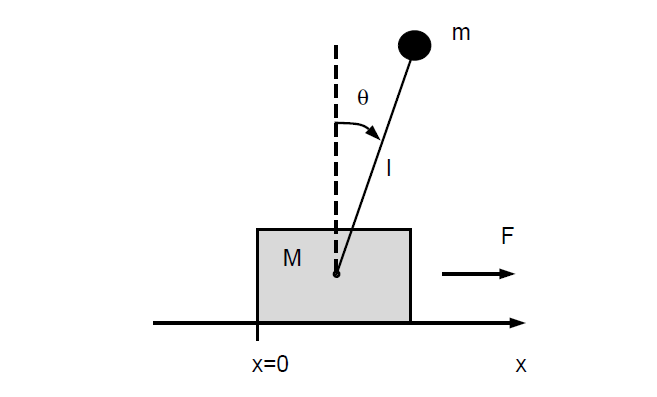

In [343]:
# Building custom non-linear model

t = np.arange(0, 20, 1e-3)


def F(x, t):
    
    return 0

def f(x, t):
    
    M = 0.5     # mass of the cart
    m = 0.2   # mass of the pendulum
    b = 0.1   # coefficient of the friction
    I = 0.006 # mass moment of inertia of the pendulum
    g = 9.81   # acceleration of gravity
    l = 0.3   # length to pendulum center of mass
    
    d_x = np.zeros((4,))
    
#     # NEW MODEL 1
#     # dot_x
#     d_x[0] = x[1]
#     # ddot_x
#     d_x[1] = (-m*g*sin(x[2])*cos(x[2]) + m*l*sin(x[2])*x[3]**2 + b*m*x[3]*cos(x[2]) + F(x, t))/(M + (1 - (cos(x[2]))**2)*m)
#     # dot_theta
#     d_x[2] = x[3]
#     # ddot_theta
#     d_x[3] = ((M + m)*(g*sin(x[2]) - b*x[3]) - (l*m*sin(x[2])*x[3]**2 + F(x, t))*cos(x[2]))/(l*(M + (1 - (cos(x[2]))**2)*m))

    # OLD MODEL
    q = (I + m*l**2)*(M + m) - (m*l**2)
    # dot_x
    d_x[0] = x[1]
    # ddot_x
    d_x[1] = ((-b*(I+m*l**2))/q)*x[1] + ((g*(m*l)**2)/q)*x[3] + (((M+m)*(I+m*l**2))/q)*F(x, t)
    # dot_theta
    d_x[2] = x[3]
    # ddot_theta
    d_x[3] = ((-b*m*l)/q)*x[1] + ((m*g*l*(I+m*l**2))/q)*x[3] + ((m*l*(M+m))/q)*F(x, t)

    return d_x




s = odeint(f, y0=[0, 0, 0, 0], t=t)


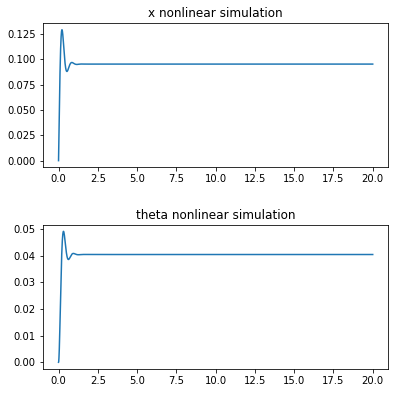

In [344]:
fig, axs = plt.subplots(2)
axs[0].plot(t, s[:, 0])
axs[0].set_title('x nonlinear simulation')
axs[1].plot(t, s[:, 2])
axs[1].set_title('theta nonlinear simulation')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.3, 
                    wspace=0.4, 
                    hspace=0.4)

## Controlled non-linear model of inverted pendulum with inputs (scipy.integrate.odeint)

#### PID

In [394]:
# new model from https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwixxrupsbf3AhWLD-wKHTGDAMoQFnoECCMQAQ&url=https%3A%2F%2Fwww.control.isy.liu.se%2Fstudent%2Ftsrt03%2Ffiles%2Finvpendpmenglish.pdf&usg=AOvVaw0FPzGKBazTXG8vmfQZ3psE
# pi - bottom stable pose, 0 - upper stable pose

global dt
dt = 1e-3

global PID_values
PID_values = [1, 0, 0.01]  # [Kp, Ki, Kd]

# Set point
global SP
SP = 3  # [rad]

t_end = 20  # [s]
t = np.linspace(0, t_end, num=int(t_end/dt))

global u_pid
# u_pid = np.zeros((np.shape(t)[0],))
u_pid = [[],[]]

global u_pid_F
# u_pid_F = np.zeros((np.shape(t)[0],))
u_pid_F = [[],[]]

global e_mon
# e_mon = np.zeros((np.shape(t)[0],))
e_mon = [[],[]]


# PID as yield generator
# PV - current value
# MV - manipulated variable
# SP - set point
# odchylka e = (SP - PV)

def PID(K, t, SP):
    MV = 0
    I = 0
    e_prev = 0
    t = 0
    t_prev = -100

    while True:
        PV, t = yield MV  # got PV <----> returns MV

        e = SP - PV
        if t - t_prev:
            dt = t - t_prev
        else:
            dt = 1e-5

        P = K[0] * e  # Kp
        I += K[1] * e * dt  # Ki
        D = -K[2] * (e - e_prev) / dt  # Kd

        # update stored data for next iteration
        MV = P + I + D
        e_prev = e
        t_prev = t
        e_mon[0].append(e)
        e_mon[1].append(t)


global controller
controller = PID(PID_values, dt, SP)  # initialise object controller
controller.send(None)  # initialise controller


def F(x, t):
    F = 0
    u = controller.send([x[0], t])  # send theta
    u_pid[0].append(u)
    u_pid[1].append(t)
    u_pid_F[0].append(F + u)
    u_pid_F[1].append(t)

    return u + F


def f(x, t):
    M = 0.9  # mass of the cart
    m = 0.2  # mass of the pendulum
    b = 0.1  # coefficient of the friction
    b_c = 0.5 
    I = 0.006  # mass moment of inertia of the pendulum
    g = 9.81  # acceleration of gravity
    l = 0.3  # length to pendulum center of mass

    d_x = np.zeros((4,))
    
    F_c = 0
    F_c = F(x, t)

    # NEW MODEL
    # dot_x
    d_x[0] = x[1]
    # ddot_x
    d_x[1] = ((-m * g * sin(x[2]) * cos(x[2]) + m * l * sin(x[2]) * x[3] ** 2 + b * m * x[3] * cos(x[2]) + F_c) / (
                M + (1 - (cos(x[2])) ** 2) * m)) - b_c*x[1]
    # dot_theta
    d_x[2] = x[3]
    # ddot_theta
    d_x[3] = ((M + m) * (g * sin(x[2]) - b * x[3]) - (l * m * sin(x[2]) * x[3] ** 2 + F_c) * cos(x[2])) / (
                l * (M + (1 - (cos(x[2])) ** 2) * m))

    #     # OLD MODEL
    #     q = (I + m*l**2)*(M + m) - (m*l**2)
    #     # dot_x
    #     d_x[0] = x[1]
    #     # ddot_x
    #     d_x[1] = ((-b*(I+m*l**2))/q)*x[1] + ((g*(m*l)**2)/q)*x[3] + (((M+m)*(I+m*l**2))/q)*F(x, t)
    #     # dot_theta
    #     d_x[2] = x[3]
    #     # ddot_theta
    #     d_x[3] = ((-b*m*l)/q)*x[1] + ((m*g*l*(I+m*l**2))/q)*x[3] + ((m*l*(M+m))/q)*F(x, t)

    return d_x


s = odeint(f, y0=[0, 0, pi, 0], t=t)

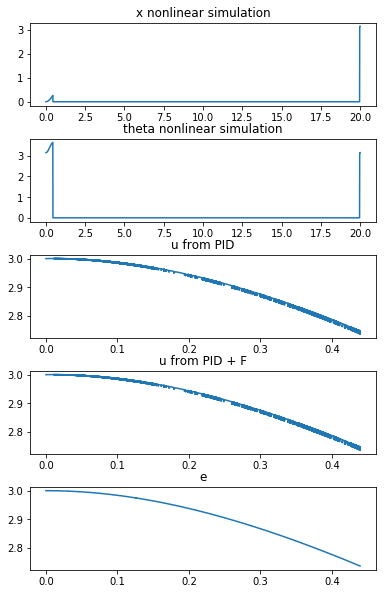

In [395]:
fig, axs = plt.subplots(5)
axs[0].plot(t, s[:, 0])
axs[0].set_title('x nonlinear simulation')
axs[1].plot(t, s[:, 2])
axs[1].set_title('theta nonlinear simulation')
axs[2].plot(u_pid[1], u_pid[0])
axs[2].set_title('u from PID')
axs[3].plot(u_pid_F[1], u_pid_F[0])
axs[3].set_title('u from PID + F')
axs[4].plot(e_mon[1], e_mon[0])
axs[4].set_title('e')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=2, 
                    wspace=0.4, 
                    hspace=0.4)

#### LQR

In [240]:
# new model from https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwixxrupsbf3AhWLD-wKHTGDAMoQFnoECCMQAQ&url=https%3A%2F%2Fwww.control.isy.liu.se%2Fstudent%2Ftsrt03%2Ffiles%2Finvpendpmenglish.pdf&usg=AOvVaw0FPzGKBazTXG8vmfQZ3psE
# pi - bottom stable pose, 0 - upper stable pose

global dt
dt = 1e-1

# Set point
global SP
SP = 3     # [m]

t_end = 20 # [s]
t = np.arange(0, t_end, dt)

# PID as yield generator
# PV - current value
# MV - manipulated variable
# SP - set point
# odchylka e = (SP - PV)
    
def F(x, t):
    
    e = SP - x[0]
    
    return -K_lqr[0][0]*e

def f(x, t):
    
    M = 0.5     # mass of the cart
    m = 0.2   # mass of the pendulum
    b = 0.1   # coefficient of the friction
    I = 0.006 # mass moment of inertia of the pendulum
    g = 9.81   # acceleration of gravity
    l = 0.3   # length to pendulum center of mass
    
    d_x = np.zeros((4,))
    
    # NEW MODEL
    # dot_x
    d_x[0] = x[1]
    # ddot_x
    d_x[1] = (-m*g*sin(x[2])*cos(x[2]) + m*l*sin(x[2])*x[3]**2 + b*m*x[3]*cos(x[2]) + F(x, t))/(M + (1 - (cos(x[2]))**2)*m)
    # dot_theta
    d_x[2] = x[3]
    # ddot_theta
    d_x[3] = ((M + m)*(g*sin(x[2]) - b*x[3]) - (l*m*sin(x[2])*x[3]**2 + F(x, t))*cos(x[2]))/(l*(M + (1 - (cos(x[2]))**2)*m))
    
#     # OLD MODEL
#     q = (I + m*l**2)*(M + m) - (m*l**2)
#     # dot_x
#     d_x[0] = x[1]
#     # ddot_x
#     d_x[1] = ((-b*(I+m*l**2))/q)*x[1] + ((g*(m*l)**2)/q)*x[3] + (((M+m)*(I+m*l**2))/q)*F(x, t)
#     # dot_theta
#     d_x[2] = x[3]
#     # ddot_theta
#     d_x[3] = ((-b*m*l)/q)*x[1] + ((m*g*l*(I+m*l**2))/q)*x[3] + ((m*l*(M+m))/q)*F(x, t)
    
    return d_x



s = odeint(f, y0=[0, 0, pi, 0], t=t)

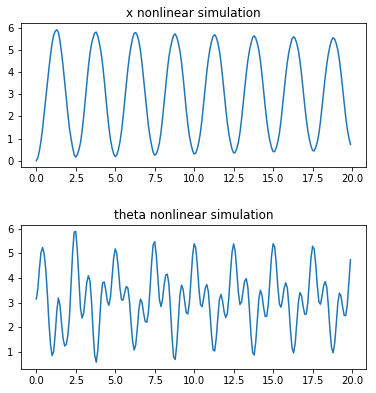

In [241]:
fig, axs = plt.subplots(2)
axs[0].plot(t, s[:, 0])
axs[0].set_title('x nonlinear simulation')
axs[1].plot(t, s[:, 2])
axs[1].set_title('theta nonlinear simulation')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.3, 
                    wspace=0.4, 
                    hspace=0.4)

In [347]:
np.shape(u_pid_F[0])[0]

4624

In [348]:
np.shape(s[:, 0])[0]

20000